<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Dependencies" data-toc-modified-id="Dependencies-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Dependencies</a></span></li><li><span><a href="#lmfit" data-toc-modified-id="lmfit-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>lmfit</a></span><ul class="toc-item"><li><span><a href="#Example" data-toc-modified-id="Example-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Example</a></span><ul class="toc-item"><li><span><a href="#Generate-some-data" data-toc-modified-id="Generate-some-data-1.2.1.1"><span class="toc-item-num">1.2.1.1&nbsp;&nbsp;</span>Generate some data</a></span></li><li><span><a href="#Do-the-fitting" data-toc-modified-id="Do-the-fitting-1.2.1.2"><span class="toc-item-num">1.2.1.2&nbsp;&nbsp;</span>Do the fitting</a></span></li></ul></li></ul></li></ul></li><li><span><a href="#NCrystal" data-toc-modified-id="NCrystal-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>NCrystal</a></span></li><li><span><a href="#Example" data-toc-modified-id="Example-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Example</a></span><ul class="toc-item"><li><span><a href="#Calculate-the-total-cross-section" data-toc-modified-id="Calculate-the-total-cross-section-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Calculate the total cross section</a></span></li><li><span><a href="#Do-a-Monte-Carlo-simulation" data-toc-modified-id="Do-a-Monte-Carlo-simulation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Do a Monte Carlo simulation</a></span><ul class="toc-item"><li><span><a href="#Calculate-scattering" data-toc-modified-id="Calculate-scattering-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Calculate scattering</a></span></li></ul></li></ul></li><li><span><a href="#Atomic-Simulation-Environment-(ASE)" data-toc-modified-id="Atomic-Simulation-Environment-(ASE)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Atomic Simulation Environment (ASE)</a></span><ul class="toc-item"><li><span><a href="#ASE-Visualization" data-toc-modified-id="ASE-Visualization-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>ASE Visualization</a></span></li><li><span><a href="#Ideal-scattering-cross-section" data-toc-modified-id="Ideal-scattering-cross-section-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Ideal scattering cross section</a></span></li><li><span><a href="#Adding-finite-resolution" data-toc-modified-id="Adding-finite-resolution-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Adding finite resolution</a></span></li></ul></li><li><span><a href="#Adding-background" data-toc-modified-id="Adding-background-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Adding background</a></span></li><li><span><a href="#Adding-both-background-and-finite-resolution" data-toc-modified-id="Adding-both-background-and-finite-resolution-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Adding both background and finite resolution</a></span></li><li><span><a href="#Different-lattice-constants" data-toc-modified-id="Different-lattice-constants-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Different lattice constants</a></span></li><li><span><a href="#Mixture" data-toc-modified-id="Mixture-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Mixture</a></span></li><li><span><a href="#Fitting-using-lmfit-and-NCAtoms-/-Mixture" data-toc-modified-id="Fitting-using-lmfit-and-NCAtoms-/-Mixture-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Fitting using lmfit and NCAtoms / Mixture</a></span><ul class="toc-item"><li><span><a href="#Fitting-to-ideal-data" data-toc-modified-id="Fitting-to-ideal-data-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Fitting to ideal data</a></span></li><li><span><a href="#Fitting-to-noisy-data" data-toc-modified-id="Fitting-to-noisy-data-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Fitting to noisy data</a></span><ul class="toc-item"><li><span><a href="#Noisy-with-background-and-resolution" data-toc-modified-id="Noisy-with-background-and-resolution-9.2.1"><span class="toc-item-num">9.2.1&nbsp;&nbsp;</span>Noisy with background and resolution</a></span></li></ul></li><li><span><a href="#Fitting-content" data-toc-modified-id="Fitting-content-9.3"><span class="toc-item-num">9.3&nbsp;&nbsp;</span>Fitting content</a></span></li></ul></li></ul></div>

# Rietveld-type analysis of time-of-flight imaging data

## Introduction

In this notebook, we will develop tools for fitting ToF data sets with scattering cross sections. Scattering cross sections will be calculated with `NCrystal` and fitting with `lmfit` and `ase` will be used to construct atomic structures whose lattice parameters then can be fitted. Besides that, we will also use the `distributions` module in `scipy` and (of course) `numpy` and `matplotlib` and also `pandas`.

### Dependencies

In [44]:
import sys
import os
import re

import numpy as np
import pandas

from matplotlib import pyplot as plt
%matplotlib inline  

from scipy.stats import distributions
import lmfit

# set path to NCrystal if needed (most likely system dependent)

ncrystal_path = '/usr/local/ncrystal'

sys.path.append(os.path.join(ncrystal_path, 'python'))

import NCrystal

import ase
from ase.build import bulk
import ase.spacegroup
from ase.visualize import view

#import scipp # ESS developed data container for multi-dimensional data with associated uncertainties and units




### lmfit
lmfit (https://lmfit.github.io/lmfit-py/intro.html) is used for fitting here. 

In these machine-learning times, probabilistic programming modules like pyro (facebook) 
or the alternative one from google could perhaps be an alternative.

#### Example
Define a model, `f`, parameters `params` to be optimized, and function to be minimized `fom` (difference between actual data and model):

In [4]:
def f(x, a, b):
    return a*x + b

##### Generate some data
Let's create the grid to evaluate the model function on and for which the target data are defined. We use the model function to create the target data and then add some random noise to them.

In [5]:
N = 20
x = distributions.uniform(loc=-2, scale=6).rvs(N) # select 20 random x values in the interval from -2 to 4

In [6]:
target_data = f(x, -1, 1) + distributions.norm(loc=0, scale=0.8).rvs(20)

Have a look

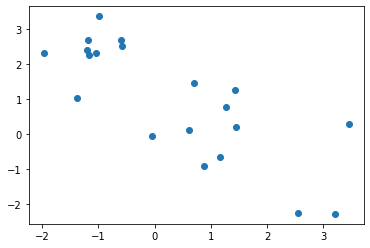

In [7]:
plt.plot(x, target_data, 'o')

##### Do the fitting

Use the lmfit `Parameters` class (https://lmfit.github.io/lmfit-py/parameters.html) for defining parameters ()

In [8]:
p = lmfit.Parameters()
p.add('a', value=1)
p.add('b', value=-1)

The function to be minimized:

In [9]:
def fom(params, x, target_data):
    return f(x,**params) - target_data

Define a function to be called for each iteration in the minimization

In [10]:
def iter_cb(params, i, resid, x, target_data):
    print("{} a={a:5.2f} b={b:5.2f}".format(i, **params.valuesdict()))

In [11]:
mn = lmfit.Minimizer(fom, p, fcn_args=(x, target_data), iter_cb=iter_cb)

In [12]:
result = mn.minimize()

-1 a= 1.00 b=-1.00
0 a= 1.00 b=-1.00
1 a= 1.00 b=-1.00
2 a= 1.00 b=-1.00
3 a= 1.00 b=-1.00
4 a=-0.82 b= 1.25
5 a=-0.82 b= 1.25
6 a=-0.82 b= 1.25
7 a=-0.82 b= 1.25


In [13]:
lmfit.report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 6
    # data points      = 20
    # variables        = 2
    chi-square         = 19.5409699
    reduced chi-square = 1.08560944
    Akaike info crit   = 3.53562019
    Bayesian info crit = 5.52708474
[[Variables]]
    a: -0.82195715 +/- 0.15045441 (18.30%) (init = 1)
    b:  1.24872327 +/- 0.23812946 (19.07%) (init = -1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b) = -0.207


Plot initial guess, fitted data, and target data

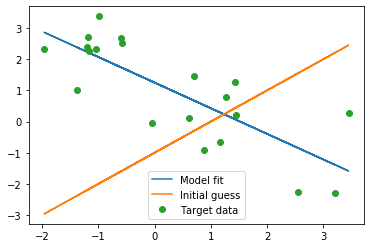

In [14]:
plot_elements = plt.plot(x, f(x, **result.params.valuesdict()), x, f(x, **p.valuesdict()), x, target_data, 'o')
plt.legend(plot_elements, ('Model fit', 'Initial guess', 'Target data') )  # a bit of an indirect way for adding labels
plt.show()

## NCrystal

NCrystal (https://github.com/mctools/ncrystal) "for Monte Carlo simulations of thermal neutrons in
crystals. Initial releases focus on scattering in single-crystals or
polycrystalline materials and powders, including both coherent elastic (Bragg)
diffraction and various models for inelastic scattering on phonons."

The Python interface is not well developed and works to a lot of extend through strings. Moreover, it does not readily give access to the different components to the total scattering cross section or keep track of whether a scatterer is isotropic or not

## Example

In [15]:
# set path to NCrystal

# create isotropic Fe scatter
pc = NCrystal.createScatter("Fe_sg229_Iron-beta.ncmat;dcutoff=0.5;temp=25C")



Where the ncmat file contains

In [16]:
print(open(os.path.join(ncrystal_path, "data/Fe_sg229_Iron-beta.ncmat")).read())

NCMAT v1
#converted from the cif file of the entry 0011215 in the AMCSD
#reference: Wyckoff R W G, Crystal Structures, vol. 1, p. 7-83, 1963.
#comment: The Debye temperature is derived from the Debye-waller factor at 293K compiled in the supplement of Acta Cryst., A52, p. 456-470, 1996
@CELL
    lengths 2.91 2.91 2.91 
    angles 90. 90. 90. 
@SPACEGROUP
    229
@ATOMPOSITIONS
    Fe 0. 0. 0.
    Fe 0.5 0.5 0.5
@DEBYETEMPERATURE
    Fe   334.6089



### Calculate the total cross section

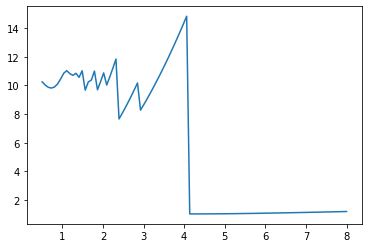

In [17]:
# create the grid we will evaluate the cross section on
wavelengths = np.linspace(0.5, 8, 100)

ekins = NCrystal.wl2ekin(wavelengths)


# Calculate total cross sections
xsections = pc.crossSectionNonOriented(ekins)

plt.plot(wavelengths, xsections)

### Do a Monte Carlo simulation

In [18]:
pc.generateScatteringNonOriented(3.5)

(2.4642330527104717, -3.493499517225087)

In [19]:
for i in range(10):
    print("A neutron was scattered with an energy change of {1:.3f} meV and scattering angle of {0:.3f} rad".format(
    *pc.generateScatteringNonOriented(3.5 ) ) )

A neutron was scattered with an energy change of -3.491 meV and scattering angle of 1.672 rad
A neutron was scattered with an energy change of -3.415 meV and scattering angle of 1.049 rad
A neutron was scattered with an energy change of -3.432 meV and scattering angle of 2.862 rad
A neutron was scattered with an energy change of 0.000 meV and scattering angle of 0.129 rad
A neutron was scattered with an energy change of -3.456 meV and scattering angle of 1.127 rad
A neutron was scattered with an energy change of -3.478 meV and scattering angle of 1.510 rad
A neutron was scattered with an energy change of -3.489 meV and scattering angle of 0.929 rad
A neutron was scattered with an energy change of -3.318 meV and scattering angle of 2.712 rad
A neutron was scattered with an energy change of -3.468 meV and scattering angle of 1.879 rad
A neutron was scattered with an energy change of -3.483 meV and scattering angle of 2.146 rad


#### Calculate scattering

In [23]:
# Perform a million events for some incoming wavelengths

wavelengths = [4.5, 5., 5.5]
sample_size = 1000000
ones = np.ones(sample_size)

data_sets = {}

for wl in wavelengths:
    data = pandas.DataFrame()
    thetas, des = pc.generateScatteringNonOriented(wl*ones)
    data['dE (meV)'] = des
    data['scat. angle (rad)'] = thetas
    data['scat. angle (deg)'] = 180*thetas/np.pi
    data_sets[wl] = data
    
data

,dE (meV),scat. angle (rad),scat. angle (deg)
0,-5.482111,1.980741,113.488101
1,-5.418114,1.608559,92.163660
2,-5.448938,0.372830,21.361591
3,-5.486856,1.509778,86.503914
4,-5.480633,2.040787,116.928479
...,...,...,...
999995,-5.468451,1.843012,105.596786
999996,-5.471681,2.191342,125.554637
999997,-5.428287,1.874786,107.417319
999998,-5.474003,2.320767,132.970153


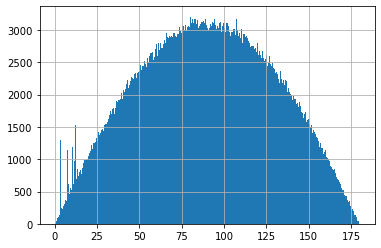

In [24]:
data_sets[wl]['scat. angle (deg)'].hist(bins=500)

The sine above reflects the isotropic scattering (non-coherent) whereas the peaks are coherent scattering (i.e. diffraction. Clearly, only scattering events are returned (i.e. no transmission). The constant wavelengths diffraction pattern at 5 AA is shown below (by zooming in)

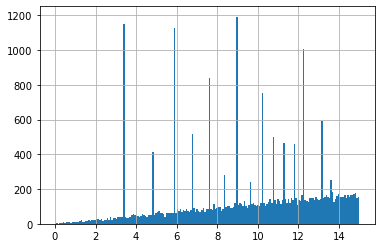

In [25]:
data_sets[wl]['scat. angle (deg)'].hist(bins=200, range=(0,15))

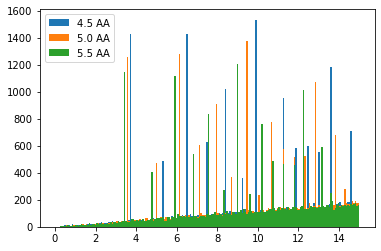

In [27]:
for wl in wavelengths:
    plt.hist(data_sets[wl]['scat. angle (deg)'], np.linspace(0,15,200), label='{} AA'.format(wl))
    
plt.legend(loc='upper left')


## Atomic Simulation Environment (ASE)
ASE is useful for constructing advanced crystal structures. Here will use the simple build features for bulk systems and the spacegroup module to get the spacegroup of a structure

In [28]:
Cu_prim = bulk('Cu')

In [29]:
print(Cu_prim.get_cell_lengths_and_angles())

[ 2.55265548  2.55265548  2.55265548 60.         60.         60.        ]


In [31]:
ase.spacegroup.get_spacegroup(Cu_prim)

Spacegroup(225, setting=1)

In [32]:
Cu_conv = bulk('Cu', cubic=True)

In [33]:
print(Cu_conv.get_cell_lengths_and_angles())

[ 3.61  3.61  3.61 90.   90.   90.  ]


In [34]:
ase.spacegroup.get_spacegroup(Cu_conv)

Spacegroup(225, setting=1)

In [35]:
Cu_bcc = bulk('Cu', crystalstructure='bcc', a = 3.)

In [36]:
print(Cu_bcc.get_cell_lengths_and_angles())

[  2.59807621   2.59807621   2.59807621 109.47122063 109.47122063
 109.47122063]


In [37]:
ase.spacegroup.get_spacegroup(Cu_bcc)

Spacegroup(229, setting=1)

Creating a unit cell matrix from lattice vector lengths and angles

In [38]:
cell = ase.geometry.cellpar_to_cell([4., 2., 5., 90., 120., 30])
cell

array([[ 4.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.73205081e+00,  1.00000000e+00,  0.00000000e+00],
       [-2.50000000e+00,  4.33012702e+00,  1.17804023e-07]])

### ASE Visualization
Different viewers can be used, e.g. nglview inline if jupyter is set up for it. The default built in one is pretty primitive but does the job. Note that it is possible to change to other viewers from the menu if they are installed, e.g. Avogadro.

In [39]:
view(Cu_conv)  

Specifically for Jupyter

In [40]:
view(Cu_conv, viewer='x3d')

In [41]:
try:
    view(Cu_conv, viewer='ngl')  # only works if nglview is setup\
except ModuleNotFoundError:
    print("nglview is not properly installed")

nglview is not properly installed


In [42]:
view(Cu_conv.repeat(3), viewer='x3d')

# Putting it together

The class below can calculate the total scattering cross section (using NCrystal) for an ASE Atoms instance.

In [254]:
class NCAtoms(object):
    lengths_format = ' {:7.5f}'
    angle_format = ' {:7.3f}'
    
    def __init__(self, atoms, debye_temperatures, resolution_function=distributions.norm,
                 background_function=lambda x: 1,
                wavelengths = np.linspace(0.5,10,100)):
        self.__dict__['_atoms'] = atoms
        self.__dict__['debye_temperatures'] = debye_temperatures
        self.__dict__['resolution_function'] = resolution_function
        self.__dict__['wavelengths'] = wavelengths
        self.__dict__['background_function'] = background_function
        self.cell_parameters = self.get_cell_lengths_and_angles()
        # Calculate the x-grid that a potential resolution function should be evaluated on
        wspan = max(self.wavelengths) - min(self.wavelengths)
        nw = len(self.wavelengths)
        dw = wspan /(nw - 1)
        minx = -wspan/2 - dw
        maxx =  wspan/2
        self.__dict__['x'] = np.linspace(minx, maxx, nw+1)

        
    def __getattr__(self, attr):
        return getattr(self._atoms, attr)
    
    def __setattr__(self, attr, value):
        setattr(self._atoms, attr, value)
        
    def __getitem__(self, item):
        return self._atoms[item]
    
    def __setitem__(self, item, value):
        self._atoms[item] = value
        
    def _get_cell_string(self):
        format_string = "@CELL\n    lengths" + 3*self.lengths_format + '\n    angles' + 3*self.angle_format + '\n'
        return format_string.format(*tuple(self.get_cell_lengths_and_angles()))
    
    def _get_spacegroup_string(self):
        return "@SPACEGROUP\n    {:d}".format(ase.spacegroup.get_spacegroup(self).no) +"\n"
    
    def _get_atom_positions_string(self):
        atom_lines = ["    {0.symbol} {0.a} {0.b} {0.c}".format(atom) for atom in self]
        return "@ATOMPOSITIONS\n" + "\n".join(atom_lines) + "\n"
    
    def _get_debye_temperature_string(self):
        return "@DEBYETEMPERATURE\n" + "\n".join(["    {} {}".format(*item) for item in self.debye_temperatures.items()]) + "\n"
    
    def __str__(self):
        #return "NCMAT v1\n" + ''.join([getattr(ncatoms, method)()  for method in filter(lambda s: s[:4]=='get_' and s[-7:]=='_string', dir(ncatoms))])
        s  = "NCMAT v1\n"
        s += self._get_cell_string()
        s += self._get_spacegroup_string()
        s += self._get_atom_positions_string()
        s += self._get_debye_temperature_string()
        return s
        
    def set_cell_parameters(self, *cell_parameters):
        self.cell_parameters = cell_parameters
        updated_cell = ase.geometry.cellpar_to_cell(cell_parameters)
        tmpcoor = self.get_scaled_positions()[:]
        self.set_cell(updated_cell)
        self.set_scaled_positions(tmpcoor)
        
    def set_lattice_constant(self, lattice_constant):
        """
        Assumes all three lattice constants are equal and that all three angles are 90 degrees
        """
        lattice_constants = 3*(lattice_constant,)
        angles = 3*(90,)
        self.set_cell_parameters(*lattice_constants, *angles)
        
    def write_ncmat(self, ncmat_filename=None):
        filecontext = str(self)
        if ncmat_filename==None:
            # NCrystal does not repeat calculations for same filenames, so ensure that filename is unique for the configuation
            self.ncmat_filename = self.get_chemical_formula() 
            self.ncmat_filename += re.sub('[@a-zA-Z\s]+', '-', filecontext[1:-1]) +'.ncmat'
        else:
            self.ncmat_filename = ncmat_filename
        with open(self.ncmat_filename,'w') as ncmat_file:
            ncmat_file.write(filecontext)
            ncmat_file.close()
            
    def create_scatter(self, dcutoff=0.5, temperature=25):
        s = "{};dcutoff={};temp={}C".format(self.ncmat_filename, dcutoff, temperature)
        self.scatter = NCrystal.createScatter(os.getcwd() + os.sep + s)
        
    def convolve_resolution(self, resolution, xsection):
        self.convolution_function = distributions.norm.pdf(self.x, scale=resolution)
        self.convolution_function /= np.sum(self.convolution_function)
        pre_data = np.ones(len(xsection)//2)*xsection[0]
        post_data = np.ones(len(xsection)//2)*xsection[-1]
        data = np.concatenate([pre_data, xsection, post_data])
        return np.convolve(data, self.convolution_function, 'valid')
    
    def plot_resolution_function(self):
        plt.plot(self.x, self.convolution_function)
        
        
    def get_powder_cross_section(self, lattice_constant=None, resolution=0, background_strength=0,
                                 dcutoff=0.5, temperature=25, 
                                 return_wl=True):
        if lattice_constant:
            self.set_lattice_constant(lattice_constant)
        self.write_ncmat()
        self.create_scatter(dcutoff=dcutoff, temperature=temperature)
        xsection = self.scatter.crossSectionNonOriented(NCrystal.wl2ekin(self.wavelengths))
        if background_strength:
            xsection += background_strength*self.background_function(self.wavelengths)
        if resolution:
            xsection = self.convolve_resolution(resolution, xsection)
        if return_wl:
            return self.wavelengths, xsection
        else:
            return xsection
        
    def get_mc_powder_cross_section(self, lattice_constant=None, resolution=0, background_strength=0,
                                 spectrum=None, dcutoff=0.5, temperature=25, 
                                 return_wl=True):
        raise NotImplementedError
        
        

In [255]:
xsection = ncatoms.get_powder_cross_section()[1]
pre_data = np.ones(len(xsection))*xsection[0]
post_data = np.ones(len(xsection))*xsection[-1]
dat = np.concatenate([pre_data, xsection, post_data])

In [256]:
ncatoms = NCAtoms(bulk('Cu', cubic=True), debye_temperatures = {'Cu': 315.1134})

### Ideal scattering cross section

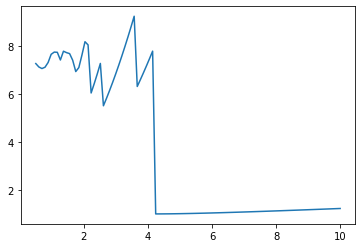

In [257]:
plt.plot(*ncatoms.get_powder_cross_section())

### Adding finite resolution
Note that the ends need to be cutoff before used for fitting of real data

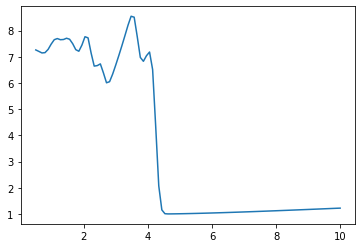

In [258]:
plt.plot(*ncatoms.get_powder_cross_section(resolution=0.1))  # resolution is gaussian (default) with width of 0.1 AA

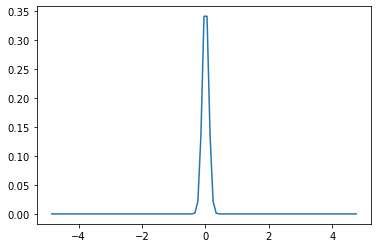

In [259]:
ncatoms.plot_resolution_function()

## Adding background
Default is flat background

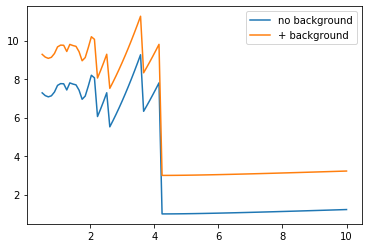

In [260]:
lines = plt.plot(*ncatoms.get_powder_cross_section(),
         *ncatoms.get_powder_cross_section(background_strength=2.)
        )
plt.legend(lines, ('no background', '+ background'))

Using another background function. At this point it is not possible to fit parameters that define the background function, only the total strength for a given set of parameter, but this should be easy to implement

Here is an example for a linear function

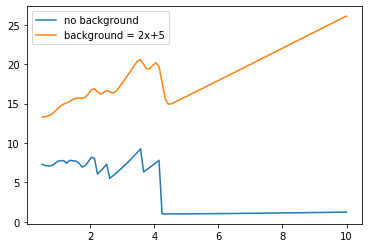

In [261]:
ncatoms2 = NCAtoms(Cu_conv, background_function=lambda x: 2*x+5, debye_temperatures={'Cu': 315.1134})
lines = plt.plot(*ncatoms2.get_powder_cross_section(), 
                 *ncatoms2.get_powder_cross_section(resolution=0.1, background_strength=1.)
                )
plt.legend(lines, ("no background", "background = 2x+5"))

## Adding both background and finite resolution

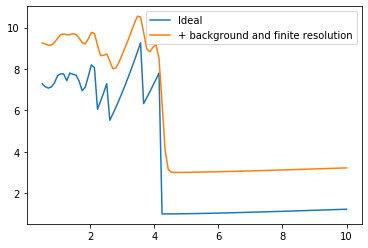

In [262]:
lines = plt.plot(*ncatoms.get_powder_cross_section(), 
                 *ncatoms.get_powder_cross_section(resolution=0.1, background_strength=2.)
                )
plt.legend(lines, ("Ideal", "+ background and finite resolution"))

## Different lattice constants

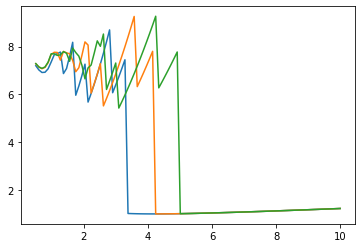

In [263]:
lattice_constant = ncatoms.get_cell_lengths_and_angles()[0]
latcs = np.linspace(0.8,1.2,3)*lattice_constant
for lc in latcs:
    plt.plot(*ncatoms.get_powder_cross_section(lattice_constant=lc), label="a={:.2f} AA".format(lc))

## Mixture

The class below calculates the scattering cross section from a list of ASE Atoms or NCAtoms instances

In [472]:
class PowderMixture(object):
    def __init__(self, ncatoms_list, weights=None, wavelengths=np.linspace(0.5, 10, 100)):
        self.ncatoms_list = ncatoms_list
        nmixture = len(ncatoms_list)
        self.wavelengths = wavelengths
        if weights == None:
            weights = np.ones(nmixture)
        self.set_weights(weights)
        # Ensure wavelengths is the same for all ncatoms set
        for ncatoms in self.ncatoms_list:
            ncatoms.wavelengths = wavelengths
            
    def set_weights(self, weights):
        self.weights = np.asarray(list(weights)) + 0.
        # normalize weights
        self.weights /= np.sum(self.weights)
        
        
    def get_powder_cross_section(self, weights=None, lattice_constants=None, **kwargs):
        # background_strengths and resolution omitted for now
        if weights != None:
            self.set_weights(weights)
        if lattice_constants != None:
            for latc, nca in zip(lattice_constants, self.ncatoms_list):
                nca.set_lattice_constant(latc)
        xsections = np.array([nca.get_powder_cross_section(return_wl=False, **kwargs) 
                              for nca in self.ncatoms_list])
        xsections = np.dot(self.weights, xsections)
        return self.wavelengths, xsections
        

Text(0.5, 0, 'Wavelength (AA)')

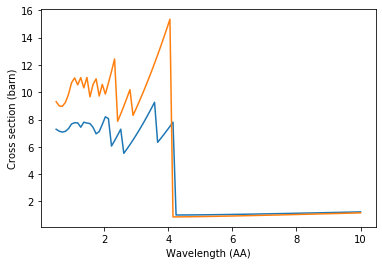

In [265]:
Cu = NCAtoms(bulk('Cu', cubic=True), debye_temperatures = {'Cu': 315.1134})  # fcc
Fe = NCAtoms(bulk('Fe', cubic=True), debye_temperatures = {'Fe' : 443.9152})  # bcc
plt.plot(*Cu.get_powder_cross_section(), label="Cu")
plt.plot(*Fe.get_powder_cross_section(), label="Fe")
plt.ylabel("Cross section (barn)")
plt.xlabel("Wavelength (AA)")

In [266]:
CuFe = PowderMixture([Cu, Fe], [1,1])

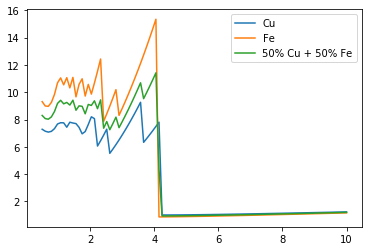

In [267]:
lines = plt.plot(*Cu.get_powder_cross_section(),
         *Fe.get_powder_cross_section(),
         *CuFe.get_powder_cross_section()
        )
plt.legend(lines, ("Cu", "Fe", "50% Cu + 50% Fe"))

Text(0.5, 0, 'Wavelength (AA)')

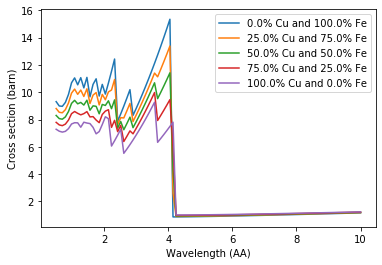

In [268]:
loweights = [(dw, 100-dw) for dw in np.linspace(0, 100, 5)]  # Use percentage content of each
CuFe_plotdata = sum([CuFe.get_powder_cross_section(weights=weights) for weights in loweights], ())
lines = plt.plot(*CuFe_plotdata)
plt.legend(lines, ("{}% Cu and {}% Fe".format(*weights) for weights in loweights))
plt.ylabel("Cross section (barn)")
plt.xlabel("Wavelength (AA)")

## Fitting using lmfit and NCAtoms / Mixture

Below class can be used to fit an atomic model to a data set

In [366]:
def print_parameters(params, i, resid):
    if i <= 10 or i%10==0:
        s = '{0:3d}: '.format(i) + ',  '.join(['{0.name} = {0.value}'.format(p) for p in params.values()]) # + ' | {}'.format(resid)
        print(s)
    else:
        pass
    
class Minimizer(object):

    def __init__(self, wavelengths, spectrum=None):
        self.set_weights(spectrum)
        self.parameters = lmfit.Parameters()
        self.parameters.add('lattice_constant', min=1., max=7., value=2., vary=True)
        self.parameters.add('resolution', min=0., max=1., value=0, vary=False)
        self.parameters.add('background_strength', min=0., value=0, vary=False)
        self.wavelengths = wavelengths
        self.results = []

    def objective_function(self, parameters): #, wavelenghts, xsection_data):
        # One could consider to use the lmfit Model class
        xsections = self._ncatoms.get_powder_cross_section(**parameters.valuesdict())
        #plt.plot(*xsections)
        return self.target_data - xsections[1]
    
    def set_model(self, ncatoms):
        if ncatoms != None:
            self._ncatoms = ncatoms
        
    def set_target_data(self, target_data):
        if type(target_data) != type(None):
            self.target_data = target_data
        
            
    def set_weights(self, weights):
        if weights != None:
            raise NotImplementedError('weighting of data is not implemented yet')
    
    def free(self, parameter):
        self.parameters[parameter].vary = True
        
    def fix(self, parameter):
        self.parameters[parameter].vary = False
        
    
    def init_minimizer(self, ncatoms=None, target_data=None):
        self.set_model(ncatoms)
        self.set_target_data(target_data)
        
    def update_parameters(self):
        """
        Update the (initial) parameters to the ones from the latest minimization
        """
        self.parameters = self.results[-1].params
    
    def run(self, method='bassinhopping'):
        self.minimizer = lmfit.Minimizer(self.objective_function, self.parameters, 
                                         iter_cb=print_parameters) #, fcn_args=(self.wavelengths, self.target_data)
        #print('\nInitial values:\n')
        #self.parameters.pretty_print()
        #print("\n\nIterations:\n")
        result = self.minimizer.minimize(method=method)
        print('\nFinal result:\n')
        #self.parameters.pretty_print()
        print(lmfit.report_fit(result))
        self.results.append(result)
        return result
        
    

In [367]:
wavelengths = np.linspace(0.5,8.0, 200)

In [368]:
Cu = NCAtoms(bulk('Cu', cubic=True), debye_temperatures = {'Cu': 315.1134}, wavelengths=wavelengths)

In [369]:
cu_xsections_ideal = Cu.get_powder_cross_section()

In [370]:
noisy = wavelengths, cu_xsections_ideal[1] + np.random.normal(size=wavelengths.size)

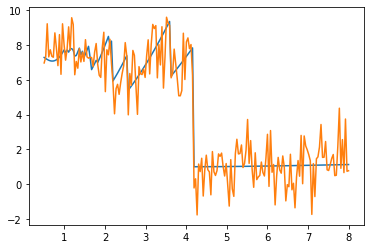

In [371]:
plt.plot(*cu_xsections_ideal, *noisy)

In [372]:
minimizer = Minimizer(wavelengths)

### Fitting to ideal data

In [373]:
minimizer.init_minimizer(ncatoms=Cu, target_data=cu_xsections_ideal[1])
minimizer.parameters['lattice_constant'].value

2.0

In [374]:
result = minimizer.run()

  1: lattice_constant = 1.9999999999999998,  resolution = 0,  background_strength = 0
  2: lattice_constant = 1.9197631770104284,  resolution = 0,  background_strength = 0
  3: lattice_constant = 2.0828990398901763,  resolution = 0,  background_strength = 0
  4: lattice_constant = 2.168349949068439,  resolution = 0,  background_strength = 0
  5: lattice_constant = 2.346449152171442,  resolution = 0,  background_strength = 0
  6: lattice_constant = 2.533349647457059,  resolution = 0,  background_strength = 0
  7: lattice_constant = 2.929533730680731,  resolution = 0,  background_strength = 0
  8: lattice_constant = 3.348478407141582,  resolution = 0,  background_strength = 0
  9: lattice_constant = 4.218724057708508,  resolution = 0,  background_strength = 0
 10: lattice_constant = 3.7812759422914968,  resolution = 0,  background_strength = 0
 20: lattice_constant = 3.604366450541674,  resolution = 0,  background_strength = 0
 30: lattice_constant = 3.6098770510288243,  resolution = 0, 

In [375]:
result

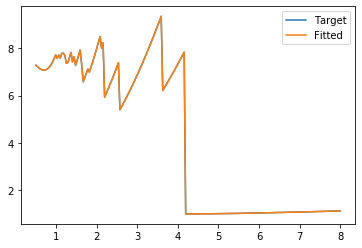

In [376]:
lines = plt.plot(*cu_xsections_ideal, *Cu.get_powder_cross_section())
plt.legend(lines, ("Target", "Fitted"))

### Fitting to noisy data

In [377]:
minimizer.init_minimizer(ncatoms=Cu, target_data=noisy[1])
minimizer.parameters

name,value,initial value,min,max,vary
lattice_constant,2.00000000,2.0,1.00000000,7.00000000,True
resolution,0.00000000,0,0.00000000,1.00000000,False
background_strength,0.00000000,0,0.00000000,inf,False


In [378]:
result = minimizer.run()

  1: lattice_constant = 1.9999999999999998,  resolution = 0,  background_strength = 0
  2: lattice_constant = 1.9197631770104284,  resolution = 0,  background_strength = 0
  3: lattice_constant = 2.0828990398901763,  resolution = 0,  background_strength = 0
  4: lattice_constant = 2.168349949068439,  resolution = 0,  background_strength = 0
  5: lattice_constant = 2.346449152171442,  resolution = 0,  background_strength = 0
  6: lattice_constant = 2.533349647457059,  resolution = 0,  background_strength = 0
  7: lattice_constant = 2.929533730680731,  resolution = 0,  background_strength = 0
  8: lattice_constant = 3.348478407141582,  resolution = 0,  background_strength = 0
  9: lattice_constant = 4.218724057708508,  resolution = 0,  background_strength = 0
 10: lattice_constant = 3.7812759422914968,  resolution = 0,  background_strength = 0
 20: lattice_constant = 3.604366450541674,  resolution = 0,  background_strength = 0
 30: lattice_constant = 3.623871469687816,  resolution = 0,  

In [379]:
result

In [380]:
minimizer.results[-1]

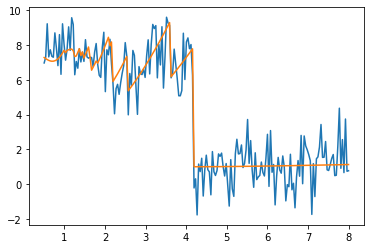

In [381]:
plt.plot(*noisy, *Cu.get_powder_cross_section())

In [382]:
minimizer.parameters

name,value,initial value,min,max,vary
lattice_constant,2.00000000,2.0,1.00000000,7.00000000,True
resolution,0.00000000,0,0.00000000,1.00000000,False
background_strength,0.00000000,0,0.00000000,inf,False


In [383]:
Cu = NCAtoms(bulk('Cu', cubic=True), debye_temperatures = {'Cu': 315.1134}, wavelengths=wavelengths)

In [389]:
minimizer.free('resolution')
minimizer.parameters['resolution'].value=0.2
minimizer.parameters

name,value,initial value,min,max,vary
lattice_constant,2.00000000,2.0,1.00000000,7.00000000,True
resolution,0.20000000,0,0.00000000,1.00000000,True
background_strength,0.00000000,0,0.00000000,inf,False


In [392]:
convolved = Cu.get_powder_cross_section(resolution=0.08)

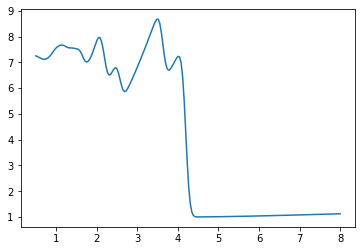

In [393]:
plt.plot(*convolved)

In [394]:
result = minimizer.run()

  1: lattice_constant = 1.9999999999999998,  resolution = 0.2,  background_strength = 0
  2: lattice_constant = 1.9197631770104284,  resolution = 0.2,  background_strength = 0
  3: lattice_constant = 1.9999999999999998,  resolution = 0.18728747002333646,  background_strength = 0
  4: lattice_constant = 2.0828990398901763,  resolution = 0.18728747002333646,  background_strength = 0
  5: lattice_constant = 2.168349949068439,  resolution = 0.18105178405097377,  background_strength = 0
  6: lattice_constant = 2.1683499490684386,  resolution = 0.19360408692607584,  background_strength = 0
  7: lattice_constant = 2.256238983107493,  resolution = 0.1967922344207279,  background_strength = 0
  8: lattice_constant = 2.4388603767419395,  resolution = 0.17796479531019566,  background_strength = 0
  9: lattice_constant = 2.6787040409899694,  resolution = 0.16732571876729257,  background_strength = 0
 10: lattice_constant = 2.777832521413571,  resolution = 0.18260302965199277,  background_strength 

ValueError: NaN values detected in your input data or the output of your objective/model function - fitting algorithms cannot handle this! Please read https://lmfit.github.io/lmfit-py/faq.html#i-get-errors-from-nan-in-my-fit-what-can-i-do for more information.

In [395]:
minimizer.fix('resolution')
minimizer.run()

  1: lattice_constant = 1.9999999999999998,  resolution = 0.2,  background_strength = 0
  2: lattice_constant = 1.9197631770104284,  resolution = 0.2,  background_strength = 0
  3: lattice_constant = 2.0828990398901763,  resolution = 0.2,  background_strength = 0
  4: lattice_constant = 2.168349949068439,  resolution = 0.2,  background_strength = 0
  5: lattice_constant = 2.346449152171442,  resolution = 0.2,  background_strength = 0
  6: lattice_constant = 2.533349647457059,  resolution = 0.2,  background_strength = 0
  7: lattice_constant = 2.929533730680731,  resolution = 0.2,  background_strength = 0
  8: lattice_constant = 3.348478407141582,  resolution = 0.2,  background_strength = 0
  9: lattice_constant = 4.218724057708508,  resolution = 0.2,  background_strength = 0
 10: lattice_constant = 3.7812759422914968,  resolution = 0.2,  background_strength = 0
 20: lattice_constant = 3.550183729409834,  resolution = 0.2,  background_strength = 0
 30: lattice_constant = 3.5434210458368

In [396]:
minimizer.parameters = minimizer.results[-1].params
minimizer.free('resolution')
minimizer.parameters

name,value,initial value,min,max,vary
lattice_constant,3.54241741,2.0,1.00000000,7.00000000,True
resolution,0.20000000,0.2,0.00000000,1.00000000,True
background_strength,0.00000000,0,0.00000000,inf,False


In [402]:
minimizer.run(method='leastsq')

 -1: lattice_constant = 3.5424174115190086,  resolution = 0.2,  background_strength = 0
  0: lattice_constant = 3.5424174115190086,  resolution = 0.2,  background_strength = 0
  1: lattice_constant = 3.5424174115190086,  resolution = 0.2,  background_strength = 0
  2: lattice_constant = 3.542417418284145,  resolution = 0.2,  background_strength = 0
  3: lattice_constant = 3.5424174115190086,  resolution = 0.20000000383556554,  background_strength = 0
  4: lattice_constant = 3.5424174115190086,  resolution = 0.06311328946746741,  background_strength = 0
  5: lattice_constant = 3.542417418284145,  resolution = 0.06311328946746741,  background_strength = 0
  6: lattice_constant = 3.5424174115190086,  resolution = 0.06311329331887722,  background_strength = 0
  7: lattice_constant = 3.5424174115190086,  resolution = 0.039822985398631605,  background_strength = 0
  8: lattice_constant = 3.542417418284145,  resolution = 0.039822985398631605,  background_strength = 0
  9: lattice_constant = 3

name,value,initial value,min,max,vary
lattice_constant,3.62814038,2.0,1.00000000,7.00000000,True
resolution,0.10848679,0,0.00000000,1.00000000,True
background_strength,0.00000000,0,0.00000000,inf,False


In [133]:
minimizer.parameters = result.params  # or minimizer.update_parameters()

#### Noisy with background and resolution

In [403]:
target_data2 = Cu.get_powder_cross_section(resolution=0.08, background_strength=2)[1] + distributions.norm.rvs(
    size=wavelengths.size)

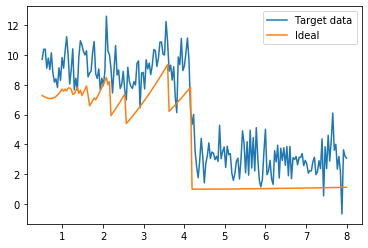

In [404]:
plt.plot(wavelengths, target_data2, label="Target data")
plt.plot(*Cu.get_powder_cross_section(), label="Ideal")
plt.legend()

In [405]:
minimizer.init_minimizer(ncatoms=Cu, target_data=target_data2)

In [406]:
minimizer.parameters

name,value,initial value,min,max,vary
lattice_constant,3.54241741,2.0,1.00000000,7.00000000,True
resolution,0.20000000,0.2,0.00000000,1.00000000,True
background_strength,0.00000000,0,0.00000000,inf,False


In [407]:
minimizer.fix('resolution')
minimizer.free('background_strength')

In [408]:
minimizer.parameters

name,value,initial value,min,max,vary
lattice_constant,3.54241741,2.0,1.00000000,7.00000000,True
resolution,0.20000000,0.2,0.00000000,1.00000000,False
background_strength,0.00000000,0,0.00000000,inf,True


In [409]:
minimizer.parameters['lattice_constant'].value = 2.
minimizer.parameters['resolution'].value=0.

In [410]:
minimizer.parameters

name,value,initial value,min,max,vary
lattice_constant,2.00000000,2.0,1.00000000,7.00000000,True
resolution,0.00000000,0.2,0.00000000,1.00000000,False
background_strength,0.00000000,0,0.00000000,inf,True


In [411]:
result = minimizer.run()

  1: lattice_constant = 1.9999999999999998,  resolution = 0.0,  background_strength = 0.0
  2: lattice_constant = 1.9197631770104284,  resolution = 0.0,  background_strength = 0.0
  3: lattice_constant = 1.9999999999999998,  resolution = 0.0,  background_strength = 3.1249999477012125e-08
  4: lattice_constant = 2.0828990398901763,  resolution = 0.0,  background_strength = 3.1249999477012125e-08
  5: lattice_constant = 2.168349949068439,  resolution = 0.0,  background_strength = 7.031249760203195e-08
  6: lattice_constant = 2.1683499490684386,  resolution = 0.0,  background_strength = 1.9531248085513653e-07
  7: lattice_constant = 2.256238983107493,  resolution = 0.0,  background_strength = 4.394530284113074e-07
  8: lattice_constant = 2.4388603767419395,  resolution = 0.0,  background_strength = 5.644529657011788e-07
  9: lattice_constant = 2.6787040409899694,  resolution = 0.0,  background_strength = 1.078612699600967e-06
 10: lattice_constant = 2.777832521413571,  resolution = 0.0,  

In [412]:
minimizer.update_parameters()
minimizer.parameters

name,value,initial value,min,max,vary
lattice_constant,3.69187970,2.0,1.00000000,7.00000000,True
resolution,0.00000000,0.0,0.00000000,1.00000000,False
background_strength,7.1447e-06,0,0.00000000,inf,True


In [413]:
minimizer.fix('lattice_constant')

In [414]:
minimizer.run()

  1: lattice_constant = 3.6918797008073727,  resolution = 0.0,  background_strength = 7.144738716435839e-06
  2: lattice_constant = 3.6918797008073727,  resolution = 0.0,  background_strength = 7.877071550588255e-06
  3: lattice_constant = 3.6918797008073727,  resolution = 0.0,  background_strength = 8.645127361317506e-06
  4: lattice_constant = 3.6918797008073727,  resolution = 0.0,  background_strength = 9.448906066689133e-06
  5: lattice_constant = 3.6918797008073727,  resolution = 0.0,  background_strength = 1.1163631811861308e-05
  6: lattice_constant = 3.6918797008073727,  resolution = 0.0,  background_strength = 1.3021248051137135e-05
  7: lattice_constant = 3.6918797008073727,  resolution = 0.0,  background_strength = 1.7165148765707627e-05
  8: lattice_constant = 3.6918797008073727,  resolution = 0.0,  background_strength = 2.1880601104973252e-05
  9: lattice_constant = 3.6918797008073727,  resolution = 0.0,  background_strength = 3.302612733735444e-05
 10: lattice_constant = 

In [416]:
minimizer.update_parameters()
minimizer.free('lattice_constant')
minimizer.parameters

name,value,initial value,min,max,vary
lattice_constant,3.69187970,3.6918797008073727,1.00000000,7.00000000,True
resolution,0.00000000,0.0,0.00000000,1.00000000,False
background_strength,1.90847437,7.144738716435839e-06,0.00000000,inf,True


In [417]:
minimizer.run()

  1: lattice_constant = 3.6918797008073727,  resolution = 0.0,  background_strength = 1.9084743726305793
  2: lattice_constant = 3.676532231747365,  resolution = 0.0,  background_strength = 1.9084743726305793
  3: lattice_constant = 3.6918797008073727,  resolution = 0.0,  background_strength = 2.0370698957736133
  4: lattice_constant = 3.707235324238875,  resolution = 0.0,  background_strength = 2.0370698957736133
  5: lattice_constant = 3.6842049215901755,  resolution = 0.0,  background_strength = 1.9405559439120266
  6: lattice_constant = 3.699556518620816,  resolution = 0.0,  background_strength = 2.0048551457697767
  7: lattice_constant = 3.6880420532002898,  resolution = 0.0,  background_strength = 1.9566140141225863
  8: lattice_constant = 3.695717858063728,  resolution = 0.0,  background_strength = 1.9887637950158341
  9: lattice_constant = 3.695717858063728,  resolution = 0.0,  background_strength = 1.860441345367426
 10: lattice_constant = 3.6918797008073727,  resolution = 0.0

In [422]:
minimizer.update_parameters()
minimizer.free('resolution')
minimizer.parameters['resolution'].value = 0.2

In [423]:
minimizer.run()

  1: lattice_constant = 3.696919586395556,  resolution = 0.2,  background_strength = 1.9146747480168984
  2: lattice_constant = 3.681821277877377,  resolution = 0.2,  background_strength = 1.9146747480168984
  3: lattice_constant = 3.696919586395556,  resolution = 0.18728747002333646,  background_strength = 1.9146747480168984
  4: lattice_constant = 3.696919586395556,  resolution = 0.2,  background_strength = 2.0436162861991862
  5: lattice_constant = 3.6868531613116806,  resolution = 0.19148965611760937,  background_strength = 1.7864913996406755
  6: lattice_constant = 3.6801441838388818,  resolution = 0.1858947108485442,  background_strength = 1.8291285650331184
  7: lattice_constant = 3.671760240797832,  resolution = 0.17899148625360933,  background_strength = 1.7864913996406746
  8: lattice_constant = 3.6801441838388818,  resolution = 0.1858947108485442,  background_strength = 1.9575759024500932
  9: lattice_constant = 3.6840575596176675,  resolution = 0.1686064972178013,  backgrou

### Fitting content

In [431]:
phases = [bulk(element, cubic=True) for element in ['Cu', 'Fe', 'Al', 'Pb', 'Ni']]
phases.append(bulk('Ti'))
phases

[Atoms(symbols='Cu4', pbc=True, cell=[3.61, 3.61, 3.61]),
 Atoms(symbols='Fe2', pbc=True, cell=[2.87, 2.87, 2.87]),
 Atoms(symbols='Al4', pbc=True, cell=[4.05, 4.05, 4.05]),
 Atoms(symbols='Pb4', pbc=True, cell=[4.95, 4.95, 4.95]),
 Atoms(symbols='Ni4', pbc=True, cell=[3.52, 3.52, 3.52]),
 Atoms(symbols='Ti2', pbc=True, cell=[[2.95, 0.0, 0.0], [-1.475, 2.554774941164094, 0.0], [0.0, 0.0, 4.6846000000000005]])]

In [438]:
debye_temperatures = [315.1134, 443.9152, 410.3542, 87.5182, 412.1374, 378.3194]
ncatoms_list = [NCAtoms(atoms, debye_temperatures = {atoms[0].symbol: temp}) 
                        for atoms, temp in zip(phases, debye_temperatures)]

Create a mixture with equal amount of each phase (here a phase is distinguished by element, but it could also by by crystal phase

In [478]:
mixture = PowderMixture(ncatoms_list, [1]*len(phases))

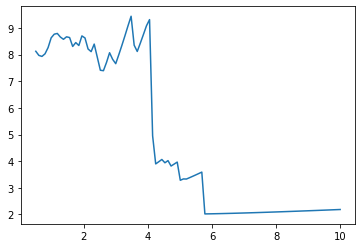

In [484]:
equal_mix = mixture.get_powder_cross_section()
plt.plot(*equal_mix)

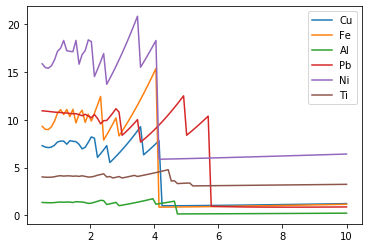

In [443]:
plt.plot(*mixture.get_powder_cross_section(weights=[1,0,0,0,0,0]), label='Cu')
plt.plot(*mixture.get_powder_cross_section(weights=[0,1,0,0,0,0]), label='Fe')
plt.plot(*mixture.get_powder_cross_section(weights=[0,0,1,0,0,0]), label='Al')
plt.plot(*mixture.get_powder_cross_section(weights=[0,0,0,1,0,0]), label='Pb')
plt.plot(*mixture.get_powder_cross_section(weights=[0,0,0,0,1,0]), label='Ni')
plt.plot(*mixture.get_powder_cross_section(weights=[0,0,0,0,0,1]), label='Ti')
plt.legend()

In [491]:
class MixtureMinimizer(Minimizer):
    def __init__(self, mixture, wavelengths, target_data):
        self.mixture = mixture
        self.target_data = target_data
        self.parameters = lmfit.Parameters()
        self.results = []
        for i, weight in enumerate(mixture.weights):
            self.parameters.add('w{:02d}'.format(i), value=weight, min=0, max=5)
            
    def objective_function(self, parameters):
        xsections = self.mixture.get_powder_cross_section(weights=parameters.valuesdict().values())
        return self.target_data - xsections[1]

        

In [492]:
mixminimizer = MixtureMinimizer(mixture, wavelengths, equal_mix)

In [493]:
mixminimizer.parameters

name,value,initial value,min,max,vary
w00,1.6470e-10,1.6470104541977996e-10,0.00000000,5.00000000,True
w01,1.9776e-11,1.9776476501459993e-11,0.00000000,5.00000000,True
w02,3.9170e-11,3.917042372701999e-11,0.00000000,5.00000000,True
w03,1.2336e-13,1.2336329928966673e-13,0.00000000,5.00000000,True
w04,0.13182386,0.13182385556837461,0.00000000,5.00000000,True
w05,0.86817614,0.8681761442078542,0.00000000,5.00000000,True


In [494]:
mixminimizer.run()

  1: w00 = 1.6470103059162966e-10,  w01 = 1.9776402737647913e-11,  w02 = 3.917033364331246e-11,  w03 = 1.2323475573339238e-13,  w04 = 0.13182385556837456,  w05 = 0.8681761442078542
  2: w00 = 0.0077043017486658205,  w01 = 1.9776402737647913e-11,  w02 = 3.917033364331246e-11,  w03 = 1.2323475573339238e-13,  w04 = 0.13182385556837456,  w05 = 0.8681761442078542
  3: w00 = 1.6470103059162966e-10,  w01 = 0.0077058464864548926,  w02 = 3.917033364331246e-11,  w03 = 1.2323475573339238e-13,  w04 = 0.13182385556837456,  w05 = 0.8681761442078542
  4: w00 = 1.6470103059162966e-10,  w01 = 1.9776402737647913e-11,  w02 = 0.007705512798031888,  w03 = 1.2323475573339238e-13,  w04 = 0.13182385556837456,  w05 = 0.8681761442078542
  5: w00 = 1.6470103059162966e-10,  w01 = 1.9776402737647913e-11,  w02 = 3.917033364331246e-11,  w03 = 0.007706601000093682,  w04 = 0.13182385556837456,  w05 = 0.8681761442078542
  6: w00 = 1.6470103059162966e-10,  w01 = 1.9776402737647913e-11,  w02 = 3.917033364331246e-11,  w03